# Forward Neuron AutoEncoder - Dimensionality Reduction of MNIST FASHION DataSet
Compare the lossy ratio between multiple latent spaces

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy


You should consider upgrading via the '/media/programming/projects/machineLearning/ML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os.path
import PIL
import PIL.Image
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable float16 bit for improved performance.
        mixed_precision.set_global_policy('mixed_float16')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-07-26 10:42:07.308206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:42:07.329779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:42:07.329928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:42:07.330639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Load DataSet

In [5]:
def loadDataFashion():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    TrainX = np.concatenate((train_images, test_images))
    TrainY = np.concatenate((train_labels, test_labels))
    # Normalize byte [0,255] -> [0,1]
    TrainX = (TrainX / 255.0)

    return TrainX, TrainY


In [6]:
EPOCHS = 192
BATCH_SIZE = 1024

trainX, trainY = loadDataFashion()


## Presenting Example Data

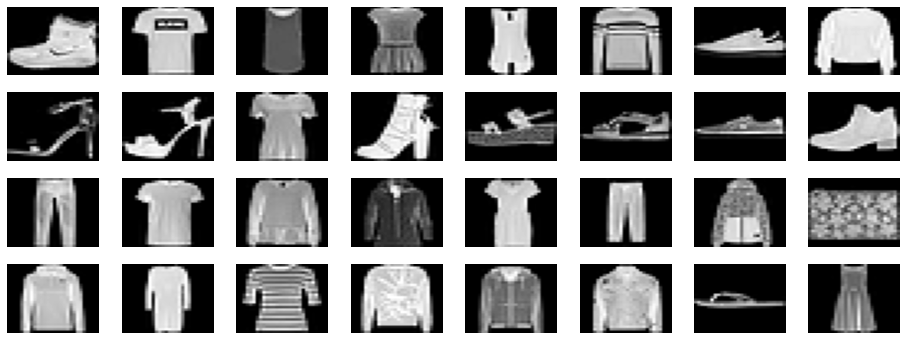

In [7]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, image in enumerate(trainX[0:nrImage]):
    ax = plt.subplot(4, 8, (index + 1))

    plt.imshow(X=((image + 1.0) / 2.0).astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


# Create Dimensionality Reduction Model

In [8]:
def model_constructor(hp, latent_space, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'sigmoid', 'linear'])

            dense_base = hp.Int(
                'dense_base', min_value=64, max_value=512, step=64)

            number_layers = hp.Int(
                'number_layers', min_value=0, max_value=3, step=1)

            encoder_dense_layers = [layers.Dense(dense_base / (2 ** i), activation=kernel_activation, kernel_initializer=kernel_init)
                                    for i in range(0, number_layers)]

            self.encoder = tf.keras.Sequential()
            self.encoder.add(layers.Flatten())

            for layer in encoder_dense_layers:
                self.encoder.add(layer)

            # Latent space.
            self.encoder.add(layers.Dense(latent_space, activation=kernel_activation, kernel_initializer=kernel_init, name="latentspace"))

            decoder_dense_layers = [layers.Dense(dense_base / (2 ** i), activation=kernel_activation, kernel_initializer=kernel_init)
                                    for i in range(0, number_layers)]

            self.decoder = tf.keras.Sequential()
            for layer in reversed(decoder_dense_layers):
                self.decoder.add(layer)

            # map the value to [0,1] to prevent color clamping.
            self.decoder.add(layers.Dense(np.prod(image_size), activation='sigmoid', kernel_initializer=kernel_init))
            self.decoder.add(layers.Reshape(image_size))

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

        def getEncoder(self):
            return self.encoder

        def getDecoder(self):
            return self.decoder

        def getModel(self):
            ae_input = layers.Input(shape=image_size, name="AE_input")
            ae_encoder_output = self.getEncoder()(ae_input)
            ae_decoder_output = self.getDecoder()(ae_encoder_output)

            return keras.Model(inputs=ae_input, outputs=ae_decoder_output)

        def compile(self, **kwargs):
            super(Autoencoder, self).compile(**kwargs)

        def summary(self, **kwargs):
            super(Autoencoder, self).summary(**kwargs)
            self.encoder.summary()

    autoencoder = Autoencoder(hp)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-2, 2e-3, 2e-4])

    hp_loss = hp.Choice('loss', ['mse', 'binary_crossentropy'])

    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    return autoencoder


## Hyperparameter
Find the best model out of all the parameters.

In [9]:

image_shape = (trainX[0].shape[0], trainX[0].shape[1], 1)

X_train, X_val, y_train, y_val = train_test_split(trainX, trainX, test_size=0.15, random_state=42)

latent_spaces = [1, 2, 4, 8, 16, 32, 64, 128]
ae_models = []

for latent_space in latent_spaces:

    def hyperparamter_model_builder(hp):
        model = model_constructor(hp, latent_space, image_shape)
        return model

    tuner = kt.Hyperband(hyperparamter_model_builder,
                         objective='val_accuracy',
                         max_epochs=20,
                         factor=4,
                         directory='cache',
                         project_name=str.format('MNIST AutoEncoder Reconstruct L{0} - {1}', latent_space, "Dimension Reduction"))

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4)

    tuner.search(X_train, y_train, epochs=EPOCHS, shuffle=True, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),
                 callbacks=[stop_early], verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_models = tuner.get_best_models(4)

    autoencoder_model = tuner.hypermodel.build(best_hps)

    ae_models.append(autoencoder_model)


Trial 44 Complete [00h 00m 08s]
val_accuracy: 0.3035985827445984

Best val_accuracy So Far: 0.5125805139541626
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit


## Train Finalize Model

In [10]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 2 * 2))
    for i in range(nrElements):

        ax = plt.subplot(2, maxNumImages, i + 1)
        plt.imshow((batchImage[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(2, maxNumImages, maxNumImages + i + 1)
        plt.imshow((output[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData[0:20]
        self.latent_space = latent_space
        self.dir_path = dir_path
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("{0}/MNISTDimRedL{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("{0}MNISTDimRedBigL{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))


In [ ]:
model_results = []

for latent_space, ae_model in zip(latent_spaces, ae_models):

    # Construct the checkpoint path for specific latent space size.
    checkpoint_path = str.format("checkpoints/mnist_autoencoder_l{}_compression/cp.ckpt", latent_space)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=ae_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        ae_model.load_weights(checkpoint_path)

    model_history = ae_model.fit(trainX, trainX,
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 verbose=2, callbacks=[cp_callback, save_images(str.format("mnist_latent_{0}", latent_space), latent_space, trainX)])
    # Save the results.
    model_results.append(model_history)

    # Save weights.
    ae_model.save_weights(checkpoint_path)

    del ae_model


## Evolution Performance

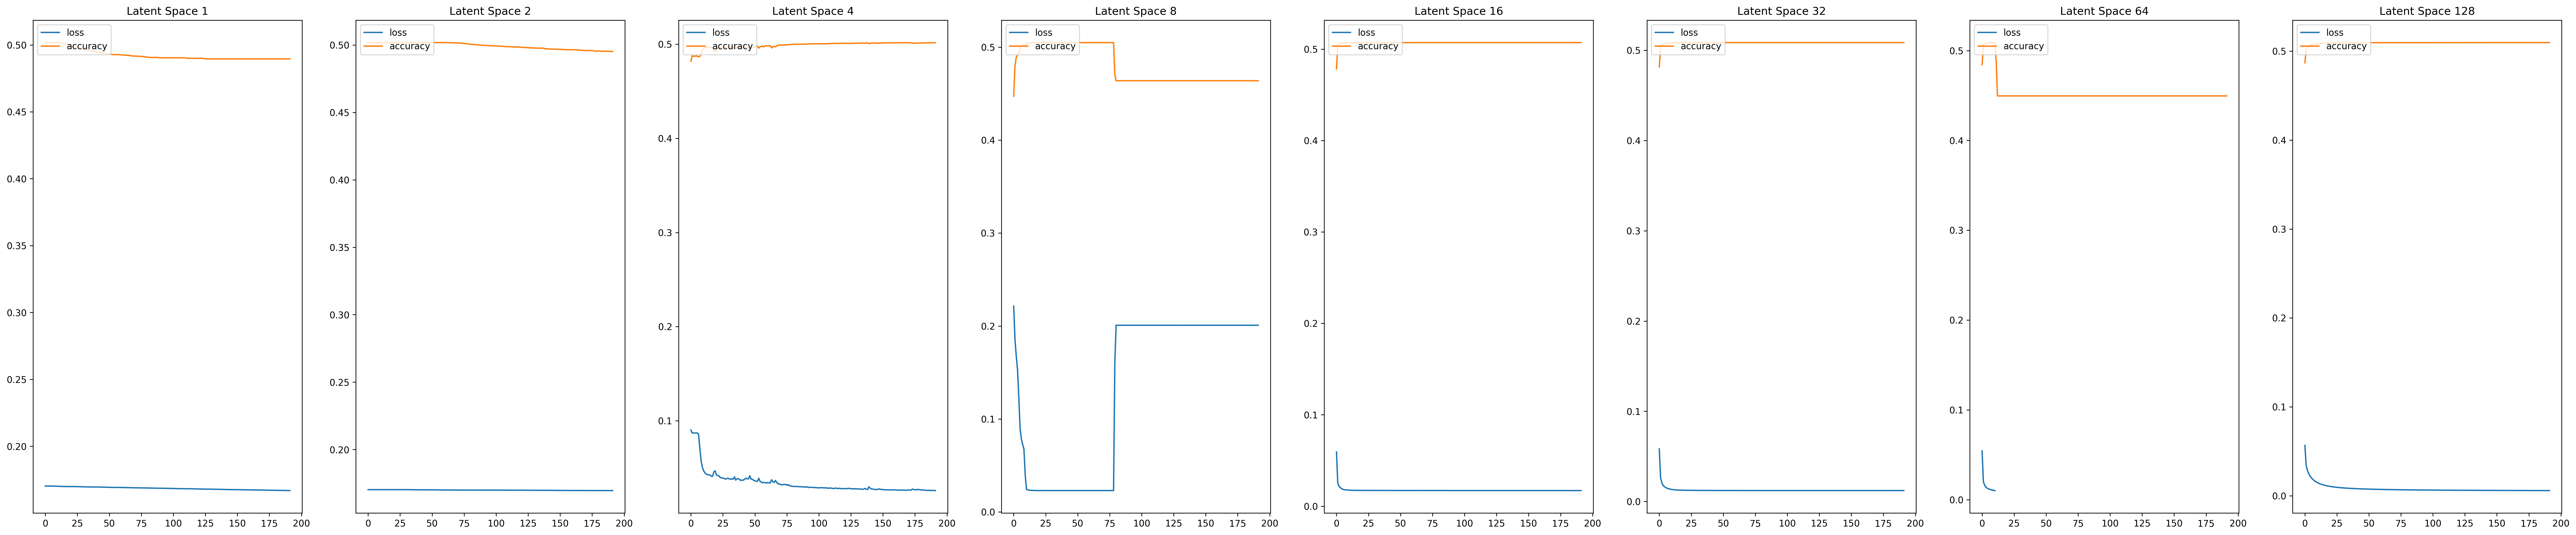

<Figure size 432x288 with 0 Axes>

In [14]:

def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10), dpi=300)
    for i, (latent_space, result) in enumerate(zip(latent_spaces, results)):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', latent_space))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "CNN {0} Performance History", "Fashion"))


## Compare Result
The following compares the original and resulted reconstructed results in respect to each lantent spaces.

In [62]:
# Plot Result
predictData = trainX[0:9]

fig = plt.figure(figsize=(len(ae_models) * 3 * 4, 3*4), dpi=300)
main_outer = fig.add_gridspec(1, len(ae_models), wspace=0.05, hspace=0.05)

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):

    result = model.predict(predictData, batch_size=256, verbose=0)
    encoder_model = model.getEncoder()

    outer = main_outer[i].subgridspec(3, 3, wspace=0.02, hspace=0.02)

    for a in range(3):
        for b in range(3):
            inner = outer[a, b].subgridspec(1, 2, wspace=0, hspace=0)

            axs = inner.subplots()  # Create all subplots for the inner grid.
            for (d,), ax in np.ndenumerate(axs):
                ax.grid(False)
                ax.axis("off")
                #ax.set(xticks=[], yticks=[])
                if d == 0:
                    ax.imshow(trainX[b * 2 + a])
                    ax.set_title('Train')
                else:
                    ax.imshow(result[b * 2 + a])
                    ax.set_title('Reconstrct')

for ax in fig.get_axes():
    ss = ax.get_subplotspec()
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())
plt.show(block=False)


## Plot Dimensional Reduction
It is possible to plot both 1 and 2 latent space dim. However, as dimension increased, it becomes impractial to plot them all toghter. Indiviually it is possible.

/home/voldie/.local/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
/home/voldie/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/voldie/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/voldie/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/voldie/.local/lib/python3.8/sit

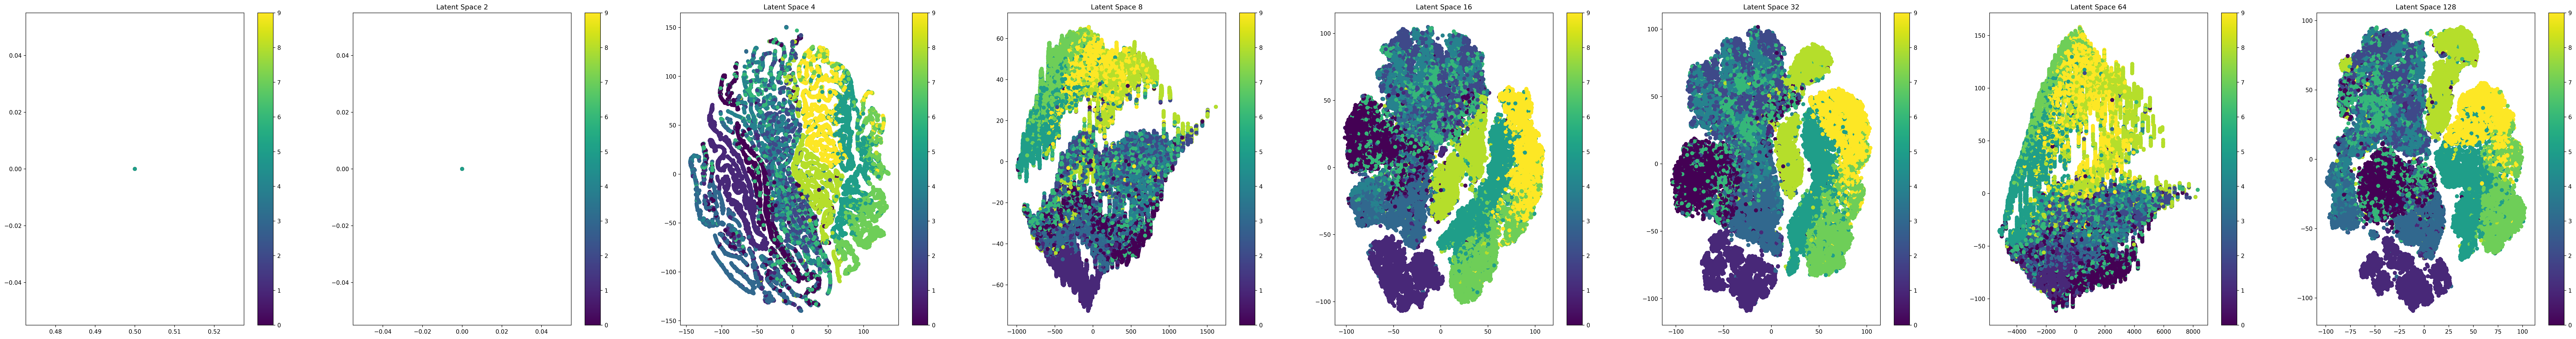

In [63]:
# Plot Result
fig = plt.figure(figsize=(len(ae_models) * 10, 2 * 5), dpi=300)
for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    ax = plt.subplot(1, len(ae_models), i + 1)
    encoder_model = model.getEncoder()
    latent_value = encoder_model.predict(trainX, batch_size=256, verbose=0)

    if len(latent_value[0]) > 1:
        tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
        X_tsne = tsne.fit_transform(latent_value)
        ax.title.set_text(str.format('Latent Space {0}', lantent_space))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=trainY)
        plt.colorbar()
    else:
        plt.scatter(latent_value[:, 0], np.zeros(len(latent_value)), c=trainY)
        plt.colorbar()
plt.show(block=False)


## Latent Space Classification
If the data can be can be clustered with the latent space. That means that it should be possible perform image classification with the latent space.

In [64]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), 1, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [65]:
# Plot Classification Prediction Result
accu_evolutions = []

fig = plt.figure(figsize=(len(ae_models) * 10, 2 * 5), dpi=300)
outer = fig.add_gridspec(1, len(ae_models), wspace=0.05, hspace=0.2, left=0.03, right=0.98, bottom=0.03, top=0.98)

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    encoder_model = model.getEncoder()
    latent_value = encoder_model.predict(trainX, batch_size=256, verbose=0)

    neigh = KNeighborsClassifier(n_neighbors=7)
    neigh.fit(latent_value, trainY)
    prob = neigh.predict_proba(latent_value)

    # Compute accuracy
    result_classification = [np.argmax(_prob) for _prob in prob]
    correct_class = trainY == result_classification
    accu = correct_class.sum() / len(trainX)
    accu_evolutions.append(accu)

    inner = gridspec.GridSpecFromSubplotSpec(3, 3,
                                             subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    #
    ax = plt.Subplot(fig, outer[i])
    ax.set_title(str.format('Latent Space {0} - Probability {1}', lantent_space, accu))
    ax.axis('off')
    fig.add_subplot(ax)

    for j in range(0, 9):
        inner_ax = plt.Subplot(fig, inner[j])
        plot_value_array(j, prob[j], trainY)
        fig.add_subplot(inner_ax)


plt.show(block=False)


In [66]:
for i, (lantent_space, accu) in enumerate(zip(latent_spaces, accu_evolutions)):
    print("Latent Space {0} - Accuracy {1}", lantent_space, accu)


Latent Space {0} - Accuracy {1} 1 0.1
Latent Space {0} - Accuracy {1} 2 0.1
Latent Space {0} - Accuracy {1} 4 0.7744
Latent Space {0} - Accuracy {1} 8 0.7625142857142857
Latent Space {0} - Accuracy {1} 16 0.8831142857142857
Latent Space {0} - Accuracy {1} 32 0.8978285714285714
Latent Space {0} - Accuracy {1} 64 0.7738
Latent Space {0} - Accuracy {1} 128 0.9040142857142857


## Presenting Models Neuron Networks

In [67]:

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    tf.keras.utils.plot_model(
        autoencoder_model, to_file=str.format('AE_{0}_latent_{1}_model.png', "Fashion", lantent_space), show_shapes=True, show_dtype=True,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96, show_layer_activations=True,
        layer_range=None
    )
    ae_model = model.getModel()
    ae_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 150913    
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         151696    
                                                                 
Total params: 302,609
Trainable params: 302,609
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 2)

##